In [1]:
import csv
import pandas as pd
import math
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
import sys 
from sklearn import svm
import torch
import torch.nn as nn
from torch.autograd import Variable


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import torch.optim as optim
#from keras.applications.imagenet_utils import decode_predictions
#from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
cuda =True

In [4]:
pho_path = './data/train_photos'
bus_path = './data/train.csv'
pho_label = 'photo_tag.csv' 
pho_bus = './data/train_photo_to_biz_ids.csv'

In [5]:
#############read the train business we need for classification
#############we can first get 1500 of them as training set and 500 of them as validation set
bus = pd.read_csv(bus_path)
img_tag = pd.read_csv(pho_label)
img_bus = pd.read_csv(pho_bus)

In [6]:
######separate training and testing set based on the business_id
train = list(bus.head(1500)['business_id'])
test = list(bus.head(500)['business_id'])
total = list(bus['business_id'])
total_label = list(bus['labels'])

In [7]:
test_img = cv2.imread(pho_path+'/'+'52779.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

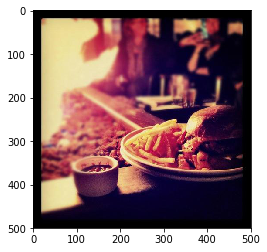

In [8]:
plt.imshow(test_img)
plt.show()

In [9]:
len(img_bus.loc[img_bus['business_id']==385])

59

In [10]:
#########filter the business, remove every business with zero label and zero image
def filter_business(total_business,total_label):
    new_bus = []
    new_label = []
    for t_b,t_l in zip(total_business,total_label):
        if type(t_l) == float or len(img_bus.loc[img_bus['business_id']==t_b])==0:
            continue
        else:
            new_bus.append(t_b)
            new_label.append(t_l)
    return new_bus,new_label

In [11]:
total,total_label = filter_business(total,total_label)

In [12]:
def progressBar(value, endvalue, bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [13]:
##############this is used to get the feature img from flattern layer based on each business
##############we only collect img_num photos, when the number of photos < img_num, we collect all of them
def collect_map(model_extractfeatures,business_id,img_num):
    bus_feature = []
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        '''
        test_img = image.load_img(pho_path+'/'+str(img)+'.jpg', target_size=(224,224))
        x = image.img_to_array(test_img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_set.append(x)
        '''
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        x = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x,(224,224))
        
        bus_feature.append(x)
    bus_feature = model_extractfeatures.predict(np.array(bus_feature))
    bus_feature = np.reshape(bus_feature,(bus_feature.shape[0],bus_feature.shape[1]*bus_feature.shape[2]*bus_feature.shape[3]))
    #bus_feature = np.array(bus_feature)
    #img_set = np.array(img_set)
    #img_set = np.reshape(img_set,(img_set.shape[0],224,224,3))
    #bus_feature = model_extractfeatures.predict(img_set)
    #################return the set of feature and the number of photo for each business
    return bus_feature,len(bus_feature)#np.array(bus_feature)
        

In [14]:
#########the bus_feature should be 2-dimension
#########this is used to reduce the dimension for each image
#########the business here is a set of business, this function will return the reduaction dimension feature for all images
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def bus_red(business,model_extractfeatures,red_dim,img_num):
    ###########used for count the number od the business to make sure the program work fine
    count = 1
    
    #reduce = PCA(n_components=red_dim)
    feature_map,num = collect_map(model_extractfeatures,business[0],img_num)
    #print(count)
    progressBar(count,len(business))
    count+=1
    
    #############################
    photo_num = []  ####the number of photos for different business
    photo_num.append(num)
    for b in business[1:]:
        bus_feature,num = collect_map(model_extractfeatures,b,img_num)
        photo_num.append(num)
        feature_map = np.vstack((feature_map,bus_feature))
        #print(count)
        progressBar(count,len(business))
        count+=1
        
    ########now we have all the feature map with size n X 25088, n is the total image numbers 
    if len(feature_map)<red_dim:
        print('There are only {0:10} images, less than {1:10d}'.format(len(feature_map), red_dim))
        
    #reduce = reduce.fit(feature_map)
    #red_feature = reduce.transform(feature_map)
    
    ######when we don't use PCA
    red_feature = feature_map
    return red_feature,photo_num#pca.components_


def gather_feature(business,model_extractfeatures,img_num):
    ###########used for count the number od the business to make sure the program work fine
    count = 1
    total_feature = [] 
    #reduce = PCA(n_components=red_dim)
    feature_map,num = collect_map(model_extractfeatures,business[0],img_num)
    #print(count)
    progressBar(count,len(business))
    total_feature.append(feature_map)
    count+=1
    
    #############################
    photo_num = []  ####the number of photos for different business
    photo_num.append(num)
    for b in business[1:]:
        bus_feature,num = collect_map(model_extractfeatures,b,img_num)
        photo_num.append(num)
        #feature_map = np.vstack((feature_map,bus_feature))
        total_feature.append(bus_feature)
        #print(count)
        progressBar(count,len(business))
        count+=1
        
    
    return total_feature#pca.components_

In [15]:
################used to get the final feature for each business
def get_bus_map(red_feature):
    return red_feature.sum(axis=0)/float(red_feature.shape[0])

In [16]:
############combine the function above to get the final feature for each business id
def get_total_map(business,model_extractfeatures,red_dim,img_num):
    
    ################get the total set for pca features and number of business photos
    ###########when use PCA use this code
    #red_features,bus_pho_num = bus_red(business,model_extractfeatures,red_dim,img_num)
    ########## otherwise
    
    
    #when using PCA use follow code 
    '''
    ###############get the first feature vector for business
    start = 0
    end = bus_pho_num[0]
    ######whenusing PCA
    bus_feature_map = get_bus_map(red_features[start:end])
    #####other wise
    #bus_feature_map = red_features[start:end]
    start = end
    
    #########when using PCA
    for num in bus_pho_num[1:]:
        end = start + num
        bus_f_map = get_bus_map(red_features[start:end])
        #bus_f_map = red_features[start:end]
        start = end
        bus_feature_map = np.vstack((bus_feature_map,bus_f_map))
    '''    
    return np.array(bus_feature_map)

In [17]:
############# one hot here should be multi hot :)
def get_one_hot(total_label):
    labels = []
    count = 0
    for t_l in total_label:
        l = [0 for i in range(9)]
        #print(count)
        for t in t_l.split(' '):
            #print(t)
            l[int(t)]=1
        count+=1
        labels.append(l)
    return labels

In [18]:
def F1_score(test_y,predict_y):
    tp = (test_y*predict_y).sum(axis=1)
    fp=[]
    fn=[]
    for t_y,p_y in zip(test_y,predict_y):
        false_p = 0
        false_n = 0
        for t,p in zip(t_y,p_y):
            if t==0 and p==1:
                false_p+=1.
            if t==1 and p==0:
                false_n+=1.
        fp.append(false_p)  
        fn.append(false_n) 
    fp = np.array(fp)
    fn = np.array(fn)
    #print(tp,fp,fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    #print(p,r)
    F1 = []
    for p,r in zip(precision,recall):
        if p==0 and r==0:
            F1.append(0)
        else:
            F1.append(2*(p*r)/(p+r))
    #print(F1)
    F1 = np.array(F1)
    F1_final = F1.sum()/len(F1)
    return F1,F1_final

In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
input_size = 25088 ########default feature size for VGG
output = 9
class model_rnn(nn.Module):
    #####the layer should cntain the size for each layer including input and output
    #####the hidden layer should have 3 layers
    def __init__(self, dropout=0, hidden1=100, hidden2 = 100 , hidden3 = 100, output=output, 
                 num_layers=1, input_size = input_size ,type_model='LSTM'):
        super(model_rnn, self).__init__()
        
        #self.word_embeddings = nn.Embedding(len(char2idx), Embedding_size)

        #if type_model=="LSTM":
        self.rnn=nn.LSTM(
                        input_size=input_size,
                        hidden_size=hidden1,
                        num_layers=num_layers,
                        dropout=dropout)
        '''
        else:
            self.rnn=nn.GRU(input_size=len(char2idx),
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        dropout=dropout)
        '''
        
        self.dense1 = nn.Linear(hidden1,hidden2)
        self.dense2 = nn.Linear(hidden2,hidden3)
        self.dense3 = nn.Linear(hidden3,output)
        #self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.type_model=type_model
        #self.init_hidden()
        
    def forward(self, input_feature):
        #sequence=var(torch.LongTensor([char2idx[x] for x in sequence]))   ####get the index for character x
        #embeds = self.word_embeddings(sequence)
        #x, self.hidden = self.rnn(embeds.view(len(sequence), 1, -1), self.hidden)
        #print(input_feature.shape)
        
        x, new_hidden = self.rnn(input_feature)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        #print(x.shape)
        #x = x.view(-1, self.hidden_size)
        #x = self.dense1(x)
        return x,new_hidden
    '''
    def init_hidden(self):
        if self.type_model=="LSTM":
            self.hidden = (Variable(torch.zeros(self.num_layers,1,self.hidden_size).cuda())
                        ,Variable(torch.zeros(self.num_layers,1,self.hidden_size)).cuda())
        else:
            self.hidden = Variable(torch.zeros(self.num_layers,1,self.hidden_size).cuda())
    '''

def var(x,option):
    ####after this the x should have 3 dimension
    x = Variable(torch.from_numpy(np.array([x]))).float()
    if cuda and option == 'keras':
        return x.cuda()
    else:
        return x

In [20]:
############transform the output from probability to one-hot vector
############define a threshold to set the label as 1 with probability higher than threshold
def get_result(output,threshold = None):
    out = []
    if threshold == None:
        ####use the average of each output set
        for o in output:
            ave = o.data.numpy().sum()/9
            hot = []
            for r in o.data.numpy():
                if r<ave:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    else:
        for o in output:
            hot = []
            for r in o.data.numpy():
                if r<threshold:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    return out

In [21]:
##################this is the part for model training and testing
#################it should return the F1 score for both training and testing set in this epoch
def training_model(model,option,criterion,optimizer,train_feature,train_label,test_feature,test_label,start,end):
    F1_train = []
    train_loss = []
    for t_f,t_l in zip(train_feature[start:end],train_label[start:end]):
        t_l = np.array(t_l)
        t_l = np.tile(t_l,(len(t_f),1))
        if option == 'pytorch':
            #############forward
            output,_ = model(var(t_f,option))
        
            #############backward
            
            loss = criterion(output[0],var(t_l,option)[0])
            train_loss.append(loss.data[0])
            loss.backward(retain_graph=False)
            optimizer.step()
            out = get_result(output[0])
            
        if option == 'keras':
            t_f = np.reshape(t_f,(t_f.shape[0],1,t_f.shape[1]))
            #########forward
            output = model.predict(var(t_f,option))
            
            #########backward
            #print(np.array(t_l).shape)
            #print(t_f.shape)
            model.fit(var(t_f,option), var(t_f,option))
            loss = model.evaluate(var(t_f,option),var(t_f,option))
            out = get_result(output)
            
        #######change output to one-hot vector
        
        
        if len(t_l.shape)==1:
            t_l = np.reshape(t_l,(t_l.shape[0],1))
        
        F1_train.append(F1_score(np.array(out),t_l)[1])
    
    ############for test set
    F1_test = []
    test_loss = []
    for t_f,t_l in zip(test_feature,test_label):
        t_l = np.array(t_l)
        t_l = np.tile(t_l,(len(t_f),1))
        if option == 'pytorch':
            #############forward
            output,_ = model(var(t_f,option))
            
            loss = criterion(output[0],var(t_l,option)[0])
            test_loss.append(loss.data[0])
            
            #######change output to one-hot vector
            out = get_result(output[0])
            
        if option == 'keras':
            t_f = np.reshape(t_f,(t_f.shape[0],1,t_f.shape[1]))
            #########forward
            output = model.predict(var(t_f,option))
            
            #######change output to one-hot vector
            out = get_result(output)
            
            #########backward
            loss = model.evaluate(var(t_f,option),var(t_f,option))
        
         
        
        if len(t_l.shape)==1:
            t_l = np.reshape(t_l,(t_l.shape[0],1))    
        
        F1_test.append(F1_score(np.array(out),t_l)[1])
    
    return np.array(F1_train).sum()/len(F1_train),np.array(train_loss).sum()/len(train_loss),np.array(F1_test).sum()/len(F1_test),np.array(test_loss).sum()/len(test_loss),model

In [22]:
###########the model should be model_rnn
##########batch represent the number of training set for every epoch
##########every time when it finished we test the model with testing set  
def train_rnn(model,option,model_name,optimizer,train_feature,train_label,test_feature,test_label,batch):
    F1_train = []
    F1_test = []
    train_loss_set = []
    test_loss_set = []
    #####train the model
    criterion = nn.BCEWithLogitsLoss()
    #####t_f represent the features for every business_id
    print('Begin training')
    count = 1
    dif_test_loss = float('inf')  # the difference between the previous test_loss and current test loss
    while 1:
        if len(test_loss_set)>10 and test_loss_set[-1]>test_loss_set[-4]:
            break
        start = 0
        end = batch
        if count%10 == 0 and option == 'pytorch':
            ###############save the model every 10 epoch
            torch.save(model, model_name+'.pt')
            
        if count%10 == 0 and option == 'keras':
            ###############save the model every 10 epoch
            model.save(model_name+'.h5')
            
        while end<len(train_label):
            
            F1_train_score,train_loss,F1_test_score,test_loss,model = training_model(model,option,criterion,optimizer,
                                                                                     train_feature,train_label,test_feature,
                                                                                     test_label,start,end)
            F1_train.append(F1_train_score)
            F1_test.append(F1_test_score)
            train_loss_set.append(train_loss)
            test_loss_set.append(test_loss)
            
            print('epoch {0:1d}, F1_test_score {1:1f}, train_loss {2:1f}, test_loss {3:1f}'.
                  format(count,F1_test_score,train_loss,test_loss))
            ###############update the data for next epoch training set
            start = end
            if end+batch>=len(train_label):
                end = len(train_label)  ###reach the end of the data set
                count+=1
                break
            else:
                end += batch
                
            count+=1
        if end == len(train_label):
            F1_train_score,train_loss,F1_test_score,test_loss,model = training_model(model,option,criterion,optimizer,
                                                                                     train_feature,train_label,test_feature,
                                                                                     test_label,start,end)
            F1_train.append(F1_train_score)
            F1_test.append(F1_test_score)
            train_loss_set.append(train_loss)
            test_loss_set.append(test_loss)
            print('epoch {0:1d}, F1_test_score {1:1f}, train_loss {2:1f}, test_loss {3:1f}'.
                   format(count,F1_test_score,train_loss,test_loss))
            count+=1
            
            
    return F1_train,train_loss_set,F1_test,test_loss_set,model
    ###########finish training
    

In [23]:
def get_total_feature(train_num,test_num,img_num,model_extractfeatures):
    print('Begin feature extracting')
    count = 1
    start = 0
    #end = batch_size
    train_feature_map = gather_feature(total[start:train_num],model_extractfeatures,img_num)
    train_label = get_one_hot(total_label[:train_num])
    
    test_feature_map = gather_feature(total[train_num:train_num+test_num],model_extractfeatures,img_num)
    test_label = get_one_hot(total_label[train_num:train_num+test_num])
    print('Finish feature extracting')
    return train_feature_map,train_label,test_feature_map,test_label

In [24]:
###########train_num is the number of business we want to choose from business_id
###########test_num is number we want to choose from the test_business_id, train_num+test_num should less than 1996

###########img_num is the number we want at most from each business
###########batch size is the num of business we want to go over for every epoch, batch_size < train_num
##########in this version we don't use PCA
##########batch < train_num
##########if option is pytorch use pytorch, if keras use keras
def train(model,option,model_name,optimizer,train_feature_map,train_label,test_feature_map,test_label,model_extractfeatures,batch):
    ##############the feature map should be (n,128) n here is 2000
    ##########here we try to use a batch to get all the PCA feature
    
    print('Begin training')
    ##############training part
    
    F1_train,train_loss,F1_test,test_loss,model = train_rnn(model,option,model_name,optimizer,train_feature_map,train_label,test_feature_map,test_label,batch)
    print('Finish training')
    

    return F1_train,train_loss,F1_test,test_loss,model

In [25]:
vgg = VGG16(weights='imagenet',include_top=False)
#model_extractfeatures_vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('flatten').output)
train_num = 100
test_num = 10
img_num = 100

In [27]:
######we first get feature map
train_feature_map,train_label,test_feature_map,test_label = get_total_feature(train_num,test_num,img_num,
                                                                              vgg)

Begin feature extracting
Percent: [--------------------------------------->] 100%Finish feature extracting


In [26]:
##########save all the numpy array feature
def save_npy(feature,name):
    np.save(str(name)+'.npy', feature)
    
def load_npy(name):
    d = np.load(str(name)+'.npy')
    return d

In [27]:
#############create a function to save the data one batch by one batch
def save_data(batch,img_num,model_extractfeatures):
    print('Begin feature extracting')
    count = 14
    start = 1300
    #end = batch_size
    while start<len(total):
        train_feature_map = gather_feature(total[start:start+batch],model_extractfeatures,img_num)
        train_label = get_one_hot(total_label[start:start+batch])
        save_npy(train_feature_map,'train_feature_map'+str(count))
        save_npy(train_label,'train_label'+str(count))
        start += batch
        print('This is {0:1d}'.format(count))
        count+=1
    print('Finish feature extracting')
    #return train_feature_map,train_label,test_feature_map,test_label

In [29]:
save_data(100,100,vgg)

Begin feature extracting
Percent: [--------------------------------------->] 100%This is 14
Percent: [--------------------------------------->] 100%This is 15
Percent: [--------------------------------------->] 100%This is 16
Percent: [--------------------------------------->] 100%This is 17
Percent: [--------------------------------------->] 100%This is 18
Percent: [--------------------------------------->] 100%This is 19
Percent: [--------------------------------------->] 100%This is 20
Finish feature extracting


In [28]:
#######train_num,test_num should be in range of 1~20
#######the test set will be the set after the train_num which is train_num:train_num+test_num
################train_num + test_num < 20
def load_data(train_num,test_num):
    train_feature = load_npy('train_feature_map'+str(1))
    train_label = load_npy('train_label'+str(1))
    if train_num != 1:
        for count in range(2,train_num+1):
            t_f = load_npy('train_feature_map'+str(count))
            t_l = load_npy('train_label'+str(count))
            #train_feature = np.vstack((train_feature,t_f))
            #train_label = np.vstack((train_label,t_l))
            train_feature = np.concatenate((train_feature,t_f), axis=0)
            train_label = np.concatenate((train_label,t_l), axis=0)
            
    ############get test set
    test_feature = load_npy('train_feature_map'+str(train_num+1))
    test_label = load_npy('train_label'+str(train_num+1))
    if test_num != 1:
        for count in range(train_num+2,train_num+test_num+1):
            t_f = load_npy('train_feature_map'+str(count))
            t_l = load_npy('train_label'+str(count))
            test_feature = np.concatenate((test_feature,t_f), axis=0)
            test_label = np.concatenate((test_label,t_l), axis=0)
    return train_feature,train_label,test_feature,test_label

In [29]:
train_feature,train_label,test_feature,test_label = load_data(10,2)

In [30]:
train_feature.shape

(1000,)

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
import numpy as np

keras_model = Sequential()


keras_model.add(LSTM(2048,input_shape =(1,25088)))
#model.add(LSTM(64, input_dim=1, input_length=1415684, return_sequences=True))

keras_model.add(Dropout(0.5))
#keras_model.add(Dense(1024))
#keras_model.add(Dense(512))
#keras_model.add(Dense(256))
keras_model.add(Dense(9))
keras_model.add(Activation('sigmoid'))

keras_model.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:

####batch < train_num
#########input size is the number of feature from pretrained model
batch = 50
###########if change the parameter use this 
model_r = model_rnn(dropout=0.1, hidden1=1024, hidden2 = 512 , hidden3 = 256,
                 num_layers=1, input_size = 25088, output = 9)

###########other wise
#model_r = torch.load('model_rnn.pt')

optimizer = optim.Adagrad(model_r.parameters(), lr=0.0002)

######change to keras_model if necessarry
model = model_r

###option = 'keras' if use model keras_model, option = 'pytorch' if using model_r
F1_train,train_loss,F1_test,test_loss,model = train(model,'pytorch','model_test',optimizer,train_feature,train_label,test_feature,test_label,vgg,batch)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Begin training
Begin training


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch 1, F1_test_score 0.516944, train_loss 0.686546, test_loss 0.652981
epoch 2, F1_test_score 0.565870, train_loss 0.653547, test_loss 0.655683
epoch 3, F1_test_score 0.550478, train_loss 0.664119, test_loss 0.678847
epoch 4, F1_test_score 0.584030, train_loss 0.644867, test_loss 0.660583
epoch 5, F1_test_score 0.584309, train_loss 0.625896, test_loss 0.653329
epoch 6, F1_test_score 0.620059, train_loss 0.659092, test_loss 0.639013
epoch 7, F1_test_score 0.604683, train_loss 0.646294, test_loss 0.647700
epoch 8, F1_test_score 0.613882, train_loss 0.654458, test_loss 0.636006
epoch 9, F1_test_score 0.622913, train_loss 0.653780, test_loss 0.615244
epoch 10, F1_test_score 0.602408, train_loss 0.617770, test_loss 0.618363
epoch 11, F1_test_score 0.570159, train_loss 0.623727, test_loss 0.634876
epoch 12, F1_test_score 0.589495, train_loss 0.636818, test_loss 0.611368
epoch 13, F1_test_score 0.624027, train_loss 0.607056, test_loss 0.589897
epoch 14, F1_test_score 0.644463, train_loss 0.

In [ ]:
###############set learning rate to 0.0002, trainingset = 1000, testing set = 200
##########hidden size 512, 256, 128
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

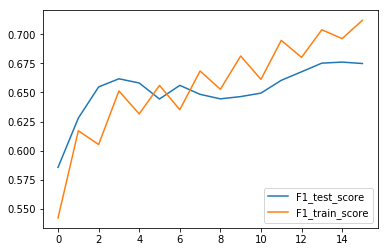

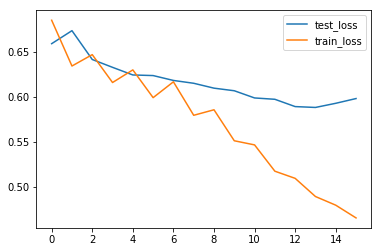

In [34]:
###############set learning rate to 0.0002, trainingset = 500, testing set = 50
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

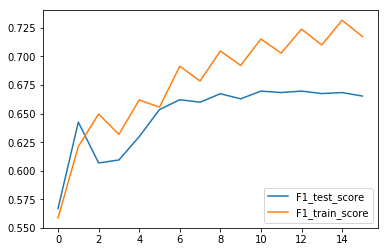

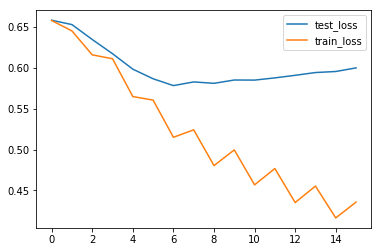

In [30]:
###############set learning rate to 0.0001, trainingset = 300, testing set = 30
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

In [31]:
###############save the model
torch.save(model, 'model_rnn.pt')

/opt/conda/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type model_rnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
count = 0
for b_id in total[train_num:train_num+test_num]:
    img_list = list(img_bus.loc[img_bus['business_id']==b_id]['photo_id'])
    print('b_id is {0:1d}, number of photos is {1:1d}, index is {2:1d}'.format(b_id,len(img_list),count))
    count+=1

b_id is 1310, number of photos is 56, index is 0
b_id is 131, number of photos is 28, index is 1
b_id is 1312, number of photos is 130, index is 2
b_id is 1313, number of photos is 144, index is 3
b_id is 1316, number of photos is 110, index is 4
b_id is 1317, number of photos is 14, index is 5
b_id is 1318, number of photos is 31, index is 6
b_id is 13, number of photos is 61, index is 7
b_id is 1320, number of photos is 26, index is 8
b_id is 132, number of photos is 50, index is 9
b_id is 1323, number of photos is 232, index is 10
b_id is 1324, number of photos is 47, index is 11
b_id is 1327, number of photos is 38, index is 12
b_id is 1328, number of photos is 1686, index is 13
b_id is 1329, number of photos is 192, index is 14
b_id is 1331, number of photos is 284, index is 15
b_id is 1332, number of photos is 75, index is 16
b_id is 1336, number of photos is 44, index is 17
b_id is 1338, number of photos is 56, index is 18
b_id is 1339, number of photos is 48, index is 19


In [34]:
###########only output nine photos
def plot_img(business_id):
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    num = 11
    if num>len(img_list):
        num = len(img_list)
    position = 1
    plt.figure(figsize=(15,15))
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        plt.subplot(3,4,position)
        plt.imshow(cv2.resize(test_img,(224,224)))
        plt.axis('off')
        position+=1
    plt.show()

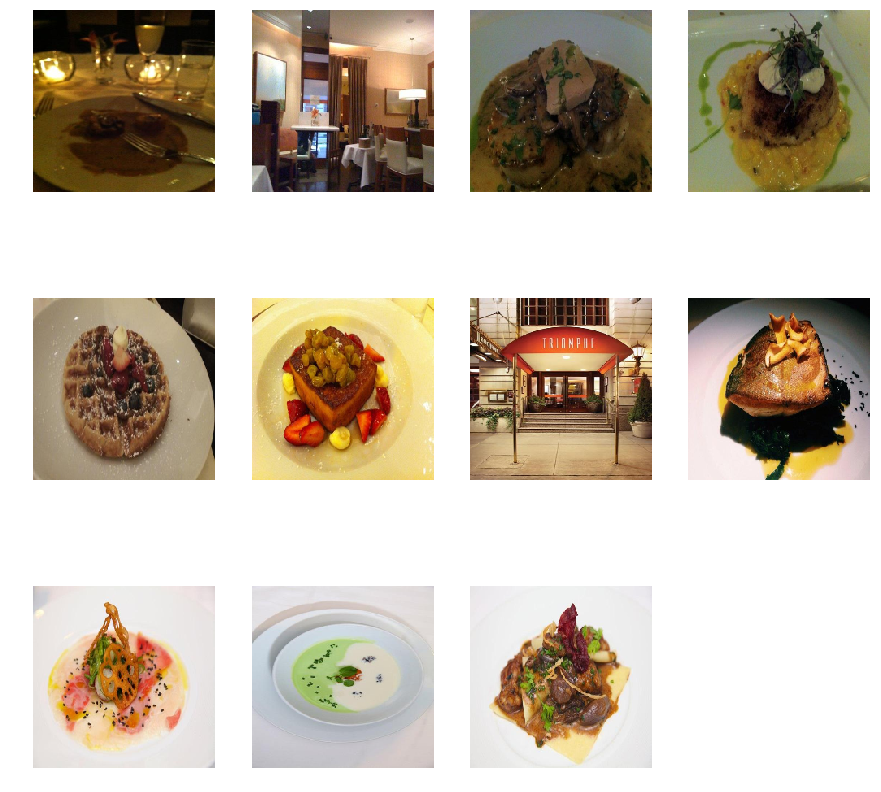

In [35]:
plot_img(1310)

In [36]:
total_one_hot = get_one_hot(total_label)

In [37]:
total_label[train_num]

'1 2 4 5 6 7'

In [38]:
model_extractfeatures_vgg

[0, 1, 1, 0, 1, 1, 1, 1, 0]

In [87]:
##################test the sample image
def sample_map(model,model_extractfeatures,business_id,img_num):
    #bus_feature = []
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        #print(test_img)
        x = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x,(224,224))
        bus_feature = model_extractfeatures.predict(np.array([x]))
        result,_ = model(var(bus_feature))
        plt.imshow(x)
        plt.title(str(get_result(result[0])))
        plt.axis('off')
        plt.show()

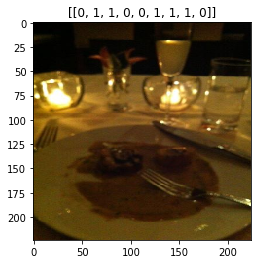

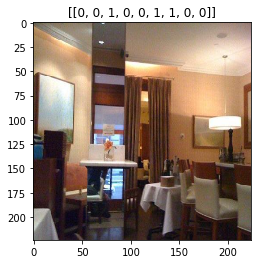

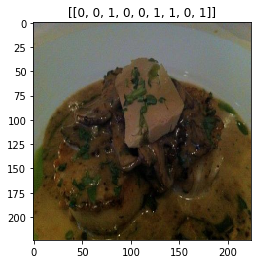

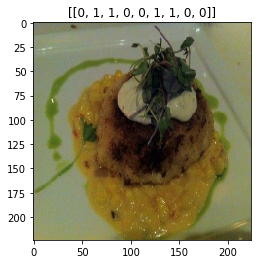

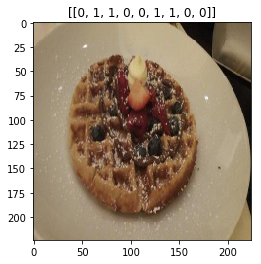

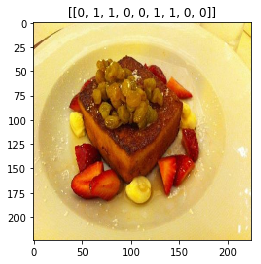

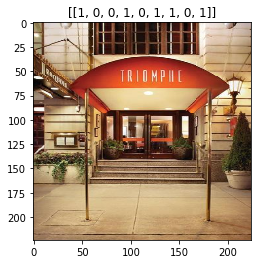

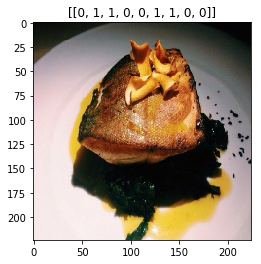

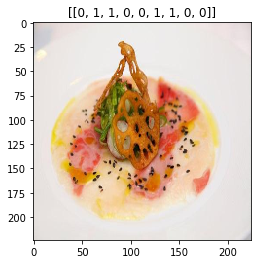

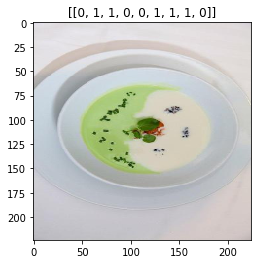

In [88]:
sample_map(model,model_extractfeatures_vgg,1310,10)

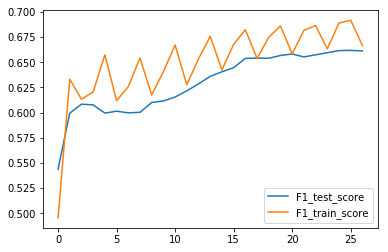

In [25]:
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()

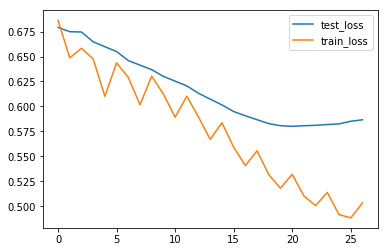

In [26]:
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
#####################the rest part is the old version for PCA no need to run them
#####################
#####################
#####################
#####################
#####################

In [ ]:
##################here we use 1500 train_business_id and 300 test_business_id
train_num = 1500
test_num = 500
red_dim = 1024
img_num = 200
batch_size = 100 ######the number of business_id that the model go through for every epoch


vgg = VGG16(weights='imagenet')
model_extractfeatures_vgg = Model(input=vgg.input, output=vgg.get_layer('flatten').output)

'''
RNV = InceptionResNetV2(weights='imagenet')
model_extractfeatures_res = Model(input=RNV.input, output=RNV.get_layer('predictions').output)
'''
##################we set 300 as the features for each business, for eaach business we take at most 800 images
F1_final,F1,pred_y,test_y = train(train_num,test_num,model_extractfeatures_vgg,red_dim,img_num,batch_size)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  # Remove the CWD from sys.path while we load stuff.


Begin feature extracting
Percent: [--------------------------------------->] 100%Finish 1
Percent: [--------------------------------------->] 100%Finish 2
Percent: [--------------------------------------->] 100%Finish 3
Percent: [--------------------------------------->] 100%Finish 4
Percent: [--------------------------------------->] 100%Finish 5
Percent: [--------------------------------------->] 100%Finish 6
Percent: [--------------------------------------->] 100%

In [23]:
F1_final

0.5466195654703718

In [20]:
F1_final#_ResNet50

0.5466195654703718

In [29]:
F1#_vgg16

0.578235362307943

In [25]:
##################check corresponding image for the label we predict
#least_img = 0
#target_bus = 0
count = 0
for b_id in total[train_num:train_num+test_num]:
    img_list = list(img_bus.loc[img_bus['business_id']==b_id]['photo_id'])
    print('b_id is {0:1d}, number of photos is {1:1d}, index is {2:1d}'.format(b_id,len(img_list),count))
    count+=1

b_id is 3737, number of photos is 344, index is 0
b_id is 3738, number of photos is 178, index is 1
b_id is 3739, number of photos is 20, index is 2
b_id is 3741, number of photos is 13, index is 3
b_id is 374, number of photos is 218, index is 4
b_id is 3743, number of photos is 316, index is 5
b_id is 3746, number of photos is 97, index is 6
b_id is 3747, number of photos is 22, index is 7
b_id is 3748, number of photos is 134, index is 8
b_id is 3750, number of photos is 175, index is 9
b_id is 3751, number of photos is 45, index is 10
b_id is 3752, number of photos is 69, index is 11
b_id is 3753, number of photos is 145, index is 12
b_id is 3754, number of photos is 33, index is 13
b_id is 3760, number of photos is 55, index is 14
b_id is 3761, number of photos is 35, index is 15
b_id is 3762, number of photos is 62, index is 16
b_id is 3764, number of photos is 293, index is 17
b_id is 376, number of photos is 62, index is 18
b_id is 3767, number of photos is 619, index is 19
b_i

b_id is 496, number of photos is 95, index is 210
b_id is 497, number of photos is 28, index is 211
b_id is 500, number of photos is 41, index is 212
b_id is 501, number of photos is 38, index is 213
b_id is 502, number of photos is 162, index is 214
b_id is 50, number of photos is 58, index is 215
b_id is 504, number of photos is 172, index is 216
b_id is 507, number of photos is 143, index is 217
b_id is 509, number of photos is 57, index is 218
b_id is 510, number of photos is 21, index is 219
b_id is 511, number of photos is 268, index is 220
b_id is 51, number of photos is 26, index is 221
b_id is 515, number of photos is 62, index is 222
b_id is 518, number of photos is 74, index is 223
b_id is 525, number of photos is 104, index is 224
b_id is 526, number of photos is 330, index is 225
b_id is 527, number of photos is 92, index is 226
b_id is 532, number of photos is 36, index is 227
b_id is 533, number of photos is 67, index is 228
b_id is 534, number of photos is 90, index is 

b_id is 847, number of photos is 41, index is 410
b_id is 848, number of photos is 7, index is 411
b_id is 850, number of photos is 55, index is 412
b_id is 85, number of photos is 81, index is 413
b_id is 851, number of photos is 49, index is 414
b_id is 852, number of photos is 44, index is 415
b_id is 853, number of photos is 81, index is 416
b_id is 856, number of photos is 34, index is 417
b_id is 857, number of photos is 933, index is 418
b_id is 862, number of photos is 49, index is 419
b_id is 870, number of photos is 106, index is 420
b_id is 87, number of photos is 40, index is 421
b_id is 872, number of photos is 13, index is 422
b_id is 873, number of photos is 577, index is 423
b_id is 876, number of photos is 82, index is 424
b_id is 878, number of photos is 34, index is 425
b_id is 881, number of photos is 15, index is 426
b_id is 882, number of photos is 36, index is 427
b_id is 883, number of photos is 34, index is 428
b_id is 884, number of photos is 47, index is 429


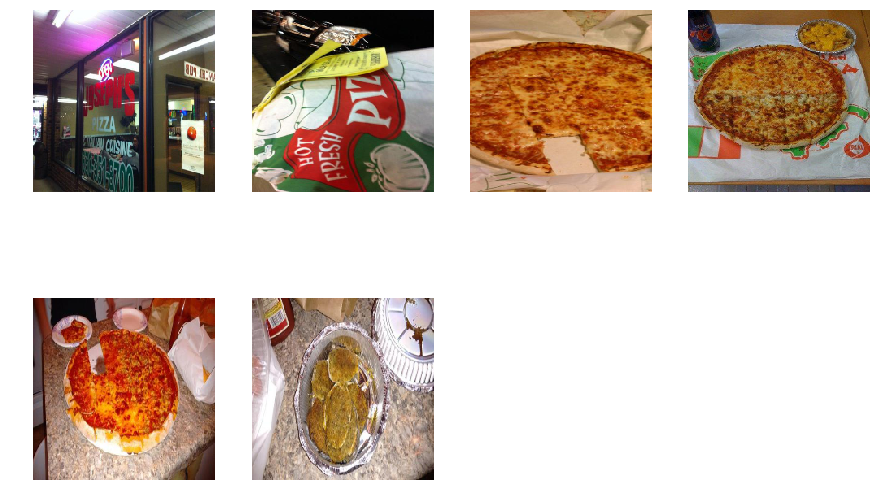

In [27]:
plot_img(3809)

In [28]:
test_y[43],pred_y[43]

(array([0, 1, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 1, 0, 0, 1, 1, 0, 1]))

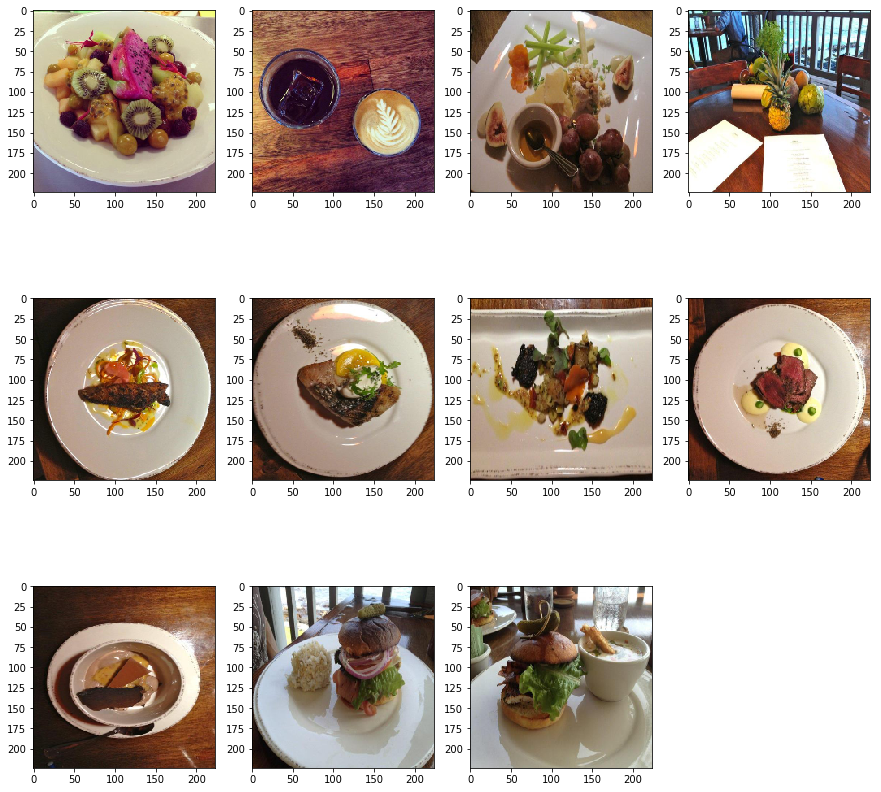

(array([0, 0, 1, 1, 0, 1, 1, 1, 1]), array([0, 1, 1, 1, 0, 1, 1, 0, 0]))

In [62]:
plot_img(1915)
test_y[37],pred_y[37]